# **Evaluating**

**Importing the Models**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
import os

models_path = r"D:\School\ITC\Y3\Semet 2\Mini Project\Project Folder\Corn-Disease-Classification\models\pre_trained_models"
loaded_models = {}

for model_file in os.listdir(models_path):
    if model_file.endswith('.keras'):
        model_path = os.path.join(models_path, model_file)
        model_name = os.path.splitext(model_file)[0]
        loaded_models[model_name] = tf.keras.models.load_model(model_path)
        print(f"Loaded model: {model_name}")

Loaded model: densenet121_model
Loaded model: mobilenetv2_model
Loaded model: resnet50_model
Loaded model: vgg16_model
Loaded model: vgg19_model


**Processing the new Images**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create generator class
test_datagen = ImageDataGenerator(rescale=1./255) 

# set batch size and image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# test data generator (new data is also processed like test data)
test_generator = test_datagen.flow_from_directory(
    r"D:\School\ITC\Y3\Semet 2\Mini Project\Project Folder\Corn-Disease-Classification\datasets\processed_data_v2\test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

print("Test generator: ", test_generator.class_indices)

Found 421 images belonging to 4 classes.
Test generator:  {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


**Confusion Metrics**

14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step


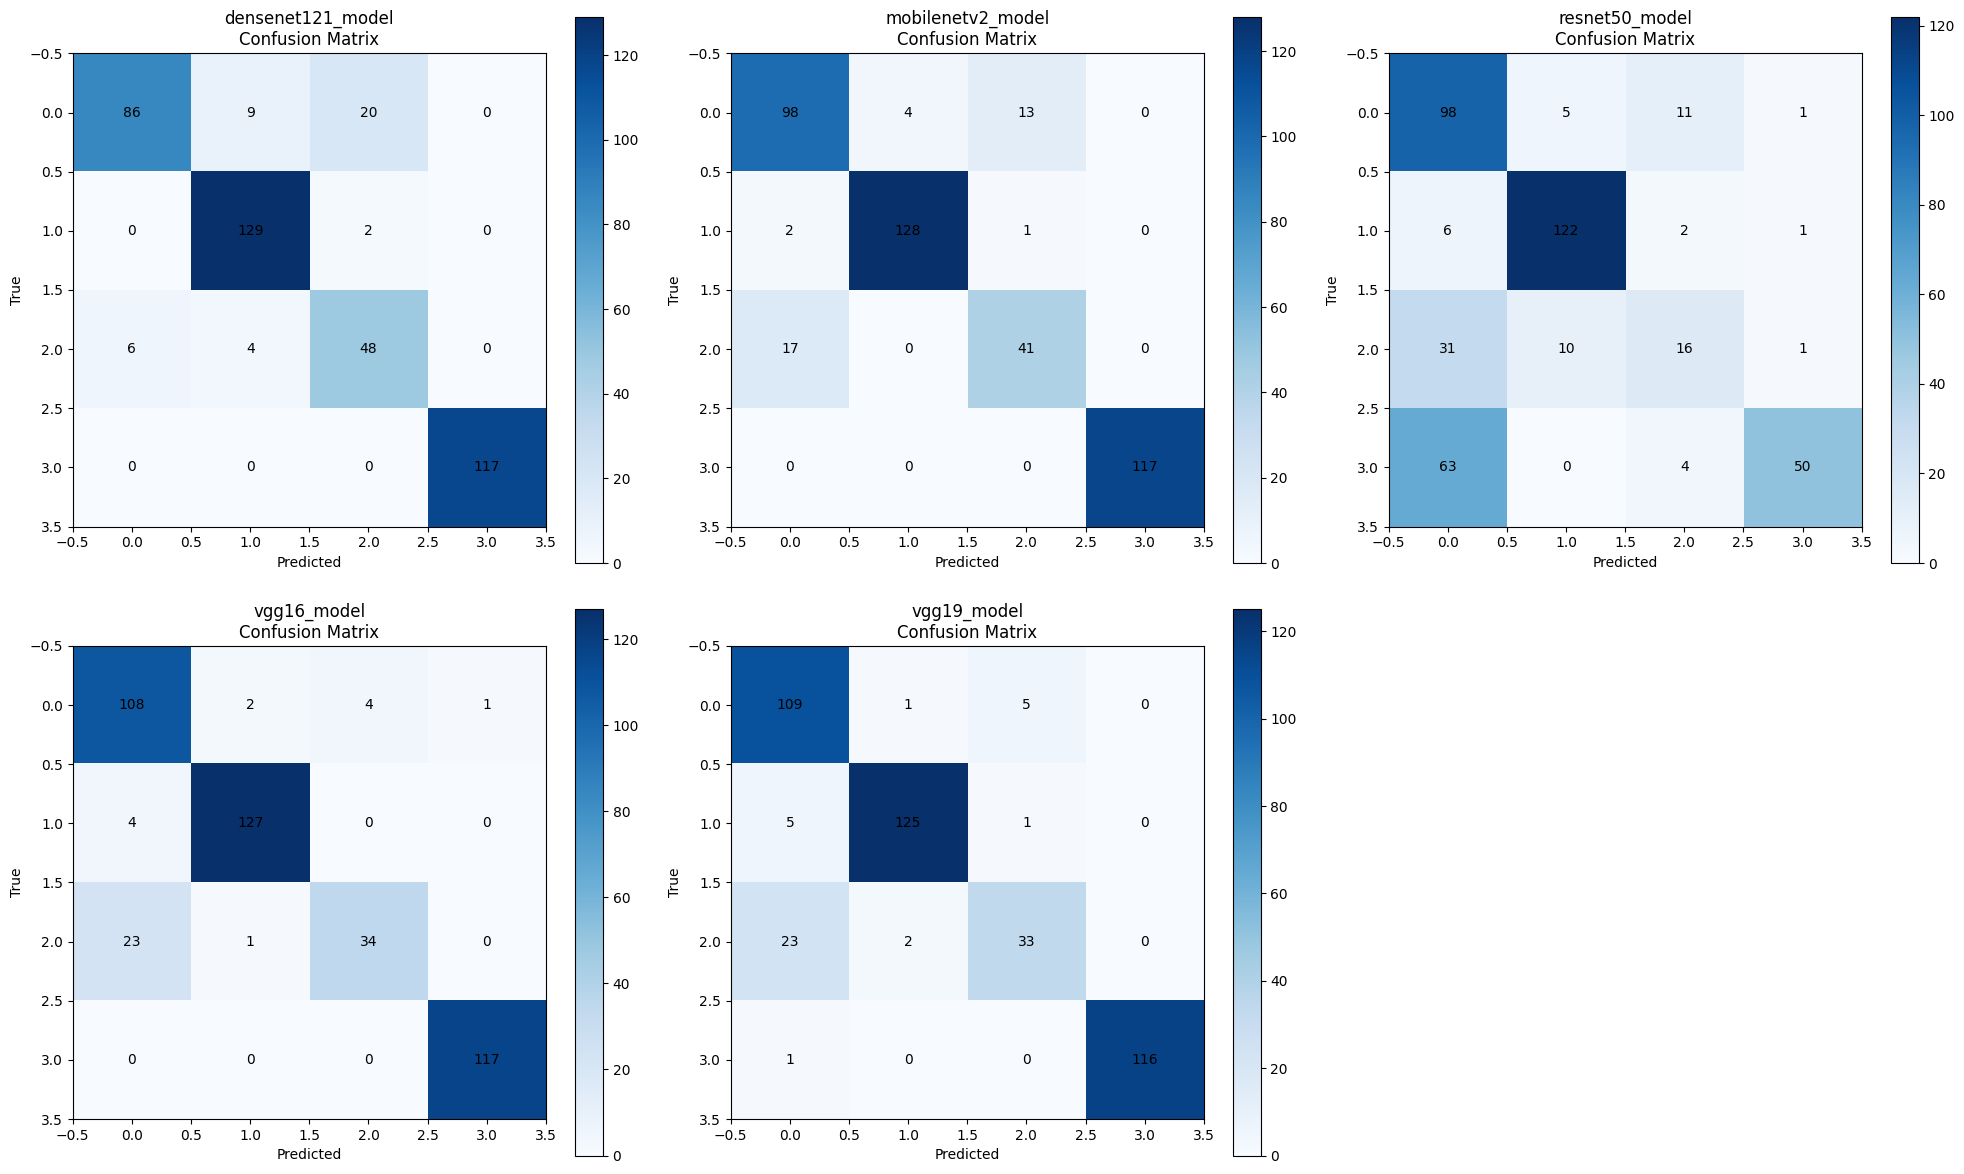

In [6]:
# Create a figure with subplots for each model
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, (model_name, model) in enumerate(loaded_models.items()):
    # Reset the generator
    test_generator.reset()
    
    # Get predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plot confusion matrix
    im = axes[idx].imshow(cm, cmap='Blues')
    axes[idx].set_title(f'{model_name}\nConfusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
    
    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j, i, cm[i, j], ha='center', va='center')
            
    # Add colorbar
    plt.colorbar(im, ax=axes[idx])

# Remove the empty subplot
axes[-1].remove()

# Adjust layout and display
plt.tight_layout()
plt.show()

**Classification Reports**

In [7]:
# Print classification reports
for model_name, model in loaded_models.items():
    print(f"\nClassification Report for {model_name}:")
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(classification_report(test_generator.classes, y_pred_classes))


Classification Report for densenet121_model:
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       115
           1       0.91      0.98      0.95       131
           2       0.69      0.83      0.75        58
           3       1.00      1.00      1.00       117

    accuracy                           0.90       421
   macro avg       0.88      0.89      0.88       421
weighted avg       0.91      0.90      0.90       421


Classification Report for mobilenetv2_model:
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       115
           1       0.97      0.98      0.97       131
           2       0.75      0.71      0.73        58
           3       1.00      1.00      1.00       117

    accuracy                           0.91       421
   macro avg       0.89      0.88      0.89       421
weighted avg 

**ROC and AUC**

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step


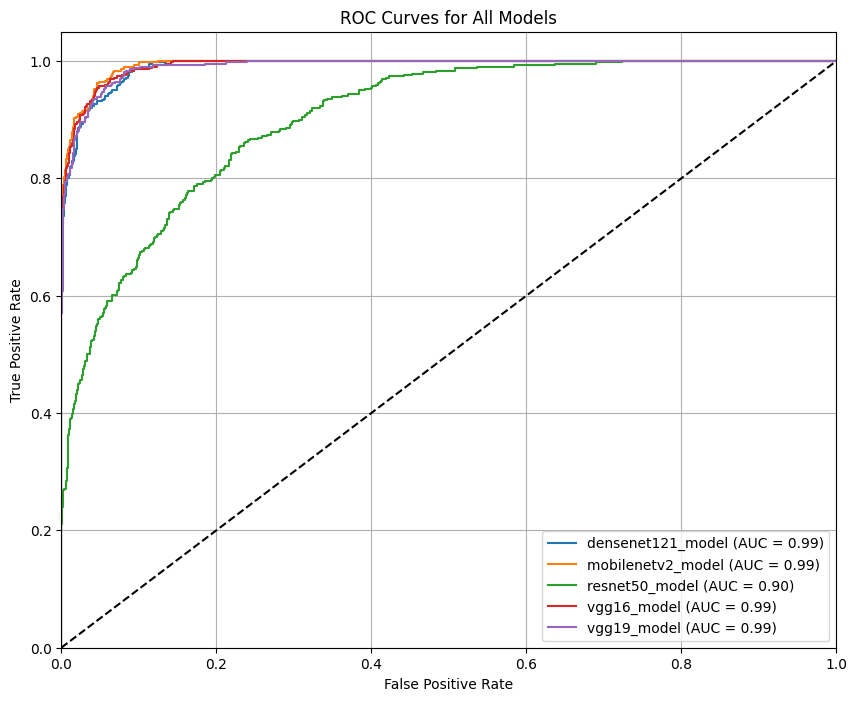

In [8]:
from sklearn.metrics import roc_curve, auc
import numpy as np

import matplotlib.pyplot as plt

# Create a figure for ROC curves
plt.figure(figsize=(10, 8))

# Calculate ROC curve and AUC for each model
for model_name, model in loaded_models.items():
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_true = tf.keras.utils.to_categorical(test_generator.classes)
    
    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    n_classes = y_true.shape[1]
    
    # Calculate micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr["micro"], tpr["micro"], 
             label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()